In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

#### 第一步：数据获取
The city of Berkeley maintains an [Open Data Portal](https://data.cityofberkeley.info/) for citizens to access data about the city.  We will be examining [Call Data](https://data.cityofberkeley.info/Public-Safety/Berkeley-PD-Calls-for-Service/k2nh-s5h5).

<img src="data/calls_desc.png" width=800px />

将数据抓取功能封装到`ds100_utils.py`

In [5]:
import ds100_utils

calls_url = 'https://data.cityofberkeley.info/api/views/k2nh-s5h5/rows.csv?accessType=DOWNLOAD'
calls_file = ds100_utils.fetch_and_cache(calls_url, '/Users/tiancaixiaohuoban/Desktop/高礼/互联网与文本分析/lec02/asg02/data/calls.csv')
calls = pd.read_csv(calls_file, warn_bad_lines=True)
calls.head()

Using cached version that was downloaded (UTC): Fri Oct 21 15:33:26 2022


,CASENO,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,Block_Location,BLKADDR,City,State,Council Districts_uniq_prepend,Council Districts_from_hg3u_n7v4,Council Districts_from_c8zs_8y7x,Zip Codes,Police Beats,Census Tracts,Council Districts
0,18092358,THEFT MISD. (UNDER $950),12/19/2018 12:00:00 AM,09:30,LARCENY,3,06/18/2019 10:28:09 AM,"2000 FOURTH ST\nBerkeley, CA\n(37.867613, -122...",2000 FOURTH ST,Berkeley,CA,7.0,1716.0,7.0,1502.0,6.0,11.0,5.0
1,19000172,BURGLARY RESIDENTIAL,12/19/2018 12:00:00 AM,00:01,BURGLARY - RESIDENTIAL,3,06/18/2019 10:28:09 AM,"1200 EVELYN AVE\nBerkeley, CA\n(37.883153, -12...",1200 EVELYN AVE,Berkeley,CA,NaN,NaN,NaN,1498.0,NaN,NaN,NaN
2,18069978,BURGLARY AUTO,12/19/2018 12:00:00 AM,08:07,BURGLARY - VEHICLE,3,06/18/2019 10:28:09 AM,"2900 SAN PABLO AVE\nBerkeley, CA\n(37.853576, ...",2900 SAN PABLO AVE,Berkeley,CA,8.0,933.0,8.0,1494.0,5.0,16.0,8.0
3,18070016,THEFT MISD. (UNDER $950),12/19/2018 12:00:00 AM,00:00,LARCENY,3,06/18/2019 10:28:09 AM,"GRAYSON STREET & 7TH ST\nBerkeley, CA\n(37.855...",GRAYSON STREET & 7TH ST,Berkeley,CA,8.0,10.0,8.0,1502.0,5.0,11.0,8.0
4,18070047,THEFT MISD. (UNDER $950),12/19/2018 12:00:00 AM,16:08,LARCENY,3,06/18/2019 10:28:09 AM,"2200 SHATTUCK AVE\nBerkeley, CA\n(37.869363, -...",2200 SHATTUCK AVE,Berkeley,CA,1.0,613.0,1.0,1496.0,11.0,32.0,1.0


In [6]:
len(calls)

4433

In [50]:
print(calls['Block_Location'].iloc[0])

2000 FOURTH ST
Berkeley, CA
(37.867613, -122.299898)


#### 针对数据进行简单观察

1. `EVENTDT` -- Contains the incorrect time
1. `EVENTTM` -- Contains the time in 24 hour format (What timezone?)
1. `CVDOW` -- Encodes the day of the week (see data documentation).
1. `InDbDate` -- Appears to be correctly formatted and appears pretty consistent in time.
1. **`Block_Location` -- a multi-line string that contains coordinates.**
1. `BLKADDR` -- Appears to be the address in `Block Location`.
1. `City` and `State` seem redundant given this is supposed to be the city of Berkeley dataset.

#### 问题1：抽取地点信息
地点信息包括经纬度，如何进行抽取？
* 观察数据，发现哪些属性可以提取经纬度
* 创建新的DataFrame`calls_lat_lon`，包含两个新列`Lat`和`Lon`

In [49]:
# 查看第一个`Block_Location`信息
calls['Block_Location'].iloc[0]

'2000 FOURTH ST\nBerkeley, CA\n(37.867613, -122.299898)'

In [52]:
# 创建新的DataFrame变量`calls_lat_lon`，包含两个新列Lat和Lon
calls_lat_lon=pd.DataFrame(columns=['Lat','Lon'])
s=pd.Series(calls['Block_Location'])#为后面的文本提取做准备
calls['Lat']=s.str.extract(r'\(([a-z0-9]+\.[a-z0-9]+),')
calls['Lon']=s.str.extract(r', ([-a-z0-9]+.[a-z0-9]+)\)')
calls_lat_lon['Lat']=calls['Lat']
calls_lat_lon['Lon']=calls['Lon']
calls_lat_lon.head(10)

,Lat,Lon
0,37.867613,-122.299898
1,37.883153,-122.292104
2,37.853576,-122.287202
3,37.855294,-122.292475
4,37.869363,-122.268028
5,37.870054,-122.284263
6,37.869105,-122.270064
7,37.888199,-122.250826
8,37.871828,-122.270516
9,37.880667,-122.29489


#### 问题2：合并经纬度信息
如何将已经抽取出的经纬度信息，合并到DataFrame变量`calls`中？

In [116]:
# 观察数据，经纬度缺失的数据有哪些？
m=0
n=0
nah=pd.DataFrame(index=['Lat','Lon'])
calls_lat_lons=calls_lat_lons.fillna(0)
for l in calls_lat_lons['Lat']:
    if l == 0:
        m+=1
for l in calls_lat_lons['Lon']:
    if l == 0:
        n+=1
nah['Lat']=m
nah['Lon']=n
print(nah)

     Lat  Lon
Lat  158  158
Lon  158  158


In [72]:
# 输出经纬度缺失的数据项的`Block_Location`属性（只需打印出前10个）
calls=calls.fillna(0)#用0代表孔雀值
calls_nah=calls[(calls.Lat== 0)|(calls.Lon == 0)]['Block_Location']
calls_nah.head(10)

20                       900 NORTHGATE AVE\nBerkeley, CA
103                    1600 SIXTY-THIRD ST\nBerkeley, CA
104               STANFORD AV & VALLEJO ST\nBerkeley, CA
151                        900 PARKSIDE DR\nBerkeley, CA
158    MARTIN LUTHER KING JR WAY &GRANT ST\nBerkeley, CA
187        CAMELIA STREET &RAILROAD TRACKS\nBerkeley, CA
196                 DOCK N &UNIVERSITY AVE\nBerkeley, CA
203                         1625 TRUMAN ST\nBerkeley, CA
207                         2100 VALLEY ST\nBerkeley, CA
336                        800 SHATTUCK SQ\nBerkeley, CA
Name: Block_Location, dtype: object

In [69]:
# 将经纬度信息合并到DataFrame变量`calls`中
#该步骤在前面已完成
calls.head()


,CASENO,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,Block_Location,BLKADDR,City,State,Council Districts_uniq_prepend,Council Districts_from_hg3u_n7v4,Council Districts_from_c8zs_8y7x,Zip Codes,Police Beats,Census Tracts,Council Districts,Lat,Lon
0,18092358,THEFT MISD. (UNDER $950),12/19/2018 12:00:00 AM,09:30,LARCENY,3,06/18/2019 10:28:09 AM,"2000 FOURTH ST\nBerkeley, CA\n(37.867613, -122...",2000 FOURTH ST,Berkeley,CA,7.0,1716.0,7.0,1502.0,6.0,11.0,5.0,37.867613,-122.299898
1,19000172,BURGLARY RESIDENTIAL,12/19/2018 12:00:00 AM,00:01,BURGLARY - RESIDENTIAL,3,06/18/2019 10:28:09 AM,"1200 EVELYN AVE\nBerkeley, CA\n(37.883153, -12...",1200 EVELYN AVE,Berkeley,CA,0.0,0.0,0.0,1498.0,0.0,0.0,0.0,37.883153,-122.292104
2,18069978,BURGLARY AUTO,12/19/2018 12:00:00 AM,08:07,BURGLARY - VEHICLE,3,06/18/2019 10:28:09 AM,"2900 SAN PABLO AVE\nBerkeley, CA\n(37.853576, ...",2900 SAN PABLO AVE,Berkeley,CA,8.0,933.0,8.0,1494.0,5.0,16.0,8.0,37.853576,-122.287202
3,18070016,THEFT MISD. (UNDER $950),12/19/2018 12:00:00 AM,00:00,LARCENY,3,06/18/2019 10:28:09 AM,"GRAYSON STREET & 7TH ST\nBerkeley, CA\n(37.855...",GRAYSON STREET & 7TH ST,Berkeley,CA,8.0,10.0,8.0,1502.0,5.0,11.0,8.0,37.855294,-122.292475
4,18070047,THEFT MISD. (UNDER $950),12/19/2018 12:00:00 AM,16:08,LARCENY,3,06/18/2019 10:28:09 AM,"2200 SHATTUCK AVE\nBerkeley, CA\n(37.869363, -...",2200 SHATTUCK AVE,Berkeley,CA,1.0,613.0,1.0,1496.0,11.0,32.0,1.0,37.869363,-122.268028


#### 问题3：对地点信息做探索式数据分析

<AxesSubplot:xlabel='count', ylabel='CVLEGEND'>

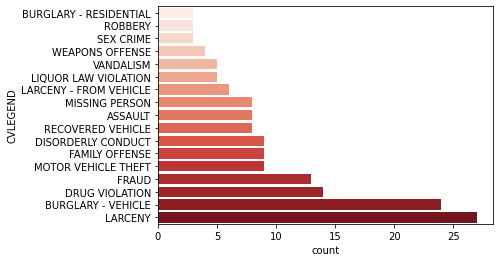

In [106]:
# 输出经纬度缺失数据记录的`CVLEGEND`属性的分布图
df=calls[(calls.Lat==0)|(calls.Lon==0)]
df_order = df.CVLEGEND.value_counts().sort_values(ascending=True).index
sns.countplot(y="CVLEGEND",data=df,order=df_order,palette=sns.color_palette("Reds",17))

<AxesSubplot:xlabel='count', ylabel='CVLEGEND'>

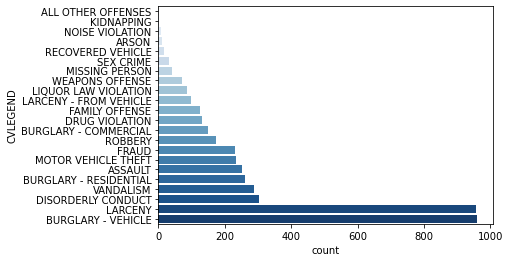

In [109]:
# 输出所有数据记录的`CVLEGEND`属性的分布图
df_order = calls.CVLEGEND.value_counts().sort_values(ascending=True).index
sns.countplot(y="CVLEGEND",data=calls,order=df_order,palette=sns.color_palette("Blues",22))

#### 观察上面两幅图，给出你的结论
* 结论1：在经纬度缺失记录中，入室盗窃和抢劫的数量占比较少，而在所有记录中，这两类的的占比较高，说明在这类犯罪上，更容易获取更详细的犯罪地点信息。相对应的，普通的盗窃罪由于嫌疑人逃窜且往往难以当场发现报案的原因，在缺失经纬度的报案记录中占比首位。
* 结论2：从整体数据来看，盗窃和车辆盗窃等犯罪的报案数量大幅度领先于其他犯罪报案，而绑票这类比较严重的犯罪的保安数量较少，一方面是绑票可能受害者也没有报案机会，另一方面可能绑匪会通过手段威胁不允许报案，因此该类案件往往报案数量较少。
* 结论3：整体上看，大部分报案记录还是集中在对财物的掠夺和盗窃上，少部分报案记录涉及对人身安全的威胁，像火拼、械斗等严重刑事案件的保安数量明显较少，这也与不同犯罪所隐含的风险相关，高风险的犯罪往往更少人选择，绝大部分犯罪者会更倾向于选择收入稳定而且风险较小的犯罪方式。

In [ ]:
# 输出不同`CVLEGEND`的缺失数据比
ratio=(calls[(calls.Lat==0)|(calls.Lon==0)].CVLEGEND.value_counts())/(calls.CVLEGEND.value_counts())
ratio=ratio.fillna(0)
df_ratio_order=ratio.sort_values(ascending=True).index
#sns.catplot(y="df")
df_ratio=pd.DataFrame(ratio)
df_ratio['CVLEGEND_ratio']=df_ratio['CVLEGEND']
df_ratio['CVLEGEND']=df_ratio.index
#print(df_ratio)
sns.catplot(y="CVLEGEND",x='CVLEGEND_ratio',kind='bar',data=df_ratio,order=df_ratio_order,palette=sns.color_palette("Oranges",22))

#### 第4步：绘制犯罪地图

In [183]:
import folium
import folium.plugins
from folium.plugins import HeatMap
calls_not_null=calls[(calls.Lat!=0)&(calls.Lon!=0)]
calls_map = folium.Map(location=[37.867613,-122.299898],zoom_start=12)#绘制Map，原始定位在Berkely，开始缩放程度是12倍
# 使用folium工具，将经纬度不为空的数据绘制在地图上
HeatMap(data=calls_not_null[['Lat','Lon']].groupby(['Lat','Lon']).sum().reset_index().values.tolist(), radius=7, max_zoom=10).add_to(calls_map)
calls_map